In [2]:
%load_ext autoreload
%autoreload 2

# import logging
from roku import Roku
import cv2
import numpy as np
import warnings
import logging
import sys
import os

from litter_monitor.util import roku as r
from litter_monitor.util import plex as p
from litter_monitor.util import mqtt as m
from litter_monitor.util import storage as s
from litter_monitor.util import fileop as f
from litter_monitor.util import opencv as o
from litter_monitor.util import image as i


logging.disable(sys.maxsize)

#load environment variables
from dotenv import load_dotenv
load_dotenv()

2021-05-16 10:06:07,758 __init__ matplotlib              wrapper() matplotlib data path: /usr/local/lib/python3.7/site-packages/matplotlib/mpl-data
2021-05-16 10:06:07,784 __init__ matplotlib              wrapper() CONFIGDIR=/root/.config/matplotlib
2021-05-16 10:06:07,794 __init__ matplotlib             <module>() matplotlib version 3.4.2
2021-05-16 10:06:07,797 __init__ matplotlib             <module>() interactive is False
2021-05-16 10:06:07,799 __init__ matplotlib             <module>() platform is linux
2021-05-16 10:06:07,800 __init__ matplotlib             <module>() loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', '_collections_abc', 'posixpath', 'genericpath', 'os

2021-05-16 10:06:07,978 __init__ matplotlib              wrapper() CACHEDIR=/root/.cache/matplotlib
2021-05-16 10:06:07,984 font_manager matplotlib.font_manager    _load_fontmanager() Using fontManager instance from /root/.cache/matplotlib/fontlist-v330.json
2021-05-16 10:06:08,335 pyplot matplotlib.pyplot       switch_backend() Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2021-05-16 10:06:08,353 pyplot matplotlib.pyplot       switch_backend() Loaded backend module://ipykernel.pylab.backend_inline version unknown.


True

### Prepare files for the analysis
We need 3 important files to process.
 
1. Reference image that is the image when the room was clean
2. Mask image. This mask image has only the image we need to monitor as white. Other areas will be black
3. Current image from the camera.

We download the current file from the camera and convert them to numpy array using opencv

In [15]:
#Input
storage_location = '/storage'
snapshot_remote_filename = 'camtest.jpg'
snapshot_url = 'http://camerapi/' + snapshot_remote_filename
roku_ip = '192.168.1.115'
plex_user = os.environ['PLEX_USER']
plex_passwd = os.environ['PLEX_PASSWD']
plex_client_name = '55" TCL Roku TV'
plex_server_name = "swarm-plexserver"
plex_library_name = "trash"
mqtt_broker = "192.168.1.136"


#automatic
images_url = "/root/machine-learning-portfolio/litter-monitor/app/resources/images/"
ref_file_list = [images_url+'base_19_54.jpg',
    images_url+'base_09_39.jpg',
    images_url+'base_15_57.jpg',
    images_url + 'mask.jpg']

images_dir = storage_location +'/images'
reference_dir = storage_location + '/references'
data_dir = storage_location + '/data'
detected_dir = storage_location + '/detected'
objects_found_dir = storage_location + '/objects_found'
special_dirs = [images_dir, reference_dir, data_dir, objects_found_dir, detected_dir]

f.format_storage_structure(special_dirs)
f.copy_referenc_files(reference_dir, ref_file_list)

chosen_ref_filename = f.get_closest_file(reference_dir)
mask_filename = reference_dir + '/mask.jpg'
data_filename = data_dir + '/found_objects.pkl'
detected_filename = detected_dir+'/detected.jpg'
snapshot_filename = images_dir + '/' + snapshot_remote_filename

f.store_current_file(images_dir, snapshot_url)

plex = p.plex_connection(plex_user, plex_passwd, plex_server_name)

### Visualize the base images
Lets visualize the 3 images we read earlier

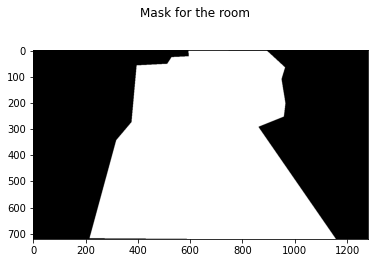

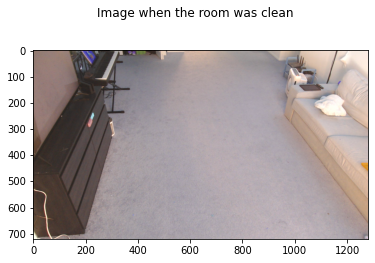

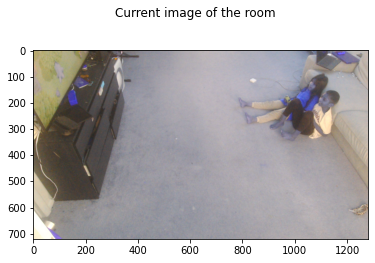

In [16]:
mask_image, ref_image, snapshot_image = o.get_base_images(mask_filename, chosen_ref_filename, snapshot_filename)

i.mdisp(mask_image, 'Mask for the room')
i.mdisp(ref_image, 'Image when the room was clean')
i.mdisp(snapshot_image, 'Current image of the room')


### Mask the images
Lets apply the mask to the 'clean room image' and 'current snapshot image'. This will black out the areas which we don't want to monitor. Areas like sofa which will always be different everytime we take an image should not be used for analysis

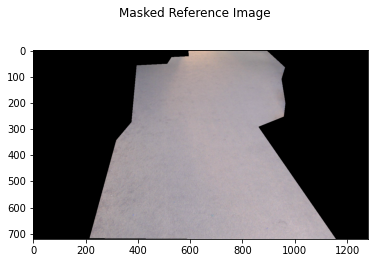

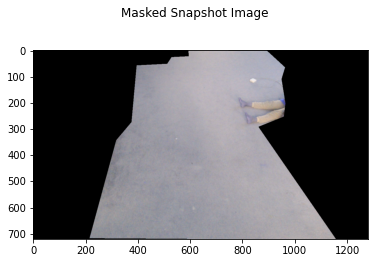

In [17]:
masked_ref_image = cv2.bitwise_and(ref_image, ref_image, mask=mask_image)
masked_snap_image = cv2.bitwise_and(snapshot_image, snapshot_image, mask=mask_image)
i.mdisp(masked_ref_image, 'Masked Reference Image')
i.mdisp(masked_snap_image, 'Masked Snapshot Image')

### Gray the images
Lets convert the images to grayscale which makes it easier to work with them without having to worry about color channels.

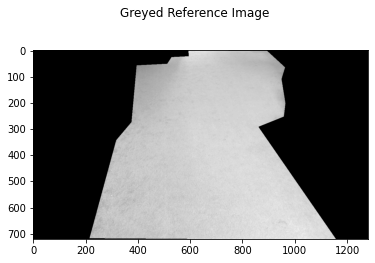

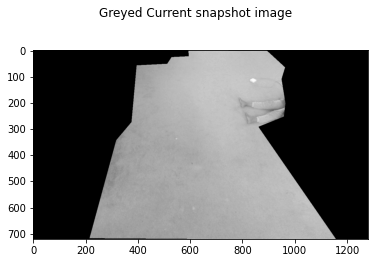

In [18]:
gray_ref_image = cv2.cvtColor(masked_ref_image, cv2.COLOR_BGR2GRAY)
gray_snap_image = cv2.cvtColor(masked_snap_image, cv2.COLOR_BGR2GRAY)
i.mdisp(gray_ref_image, 'Greyed Reference Image')
i.mdisp(gray_snap_image, 'Greyed Current snapshot image')

### Blur the images
We need to smudge the images a bit to get a continuous blob of section that changed. Otherwise, we would get grainy images where individual pixels matched

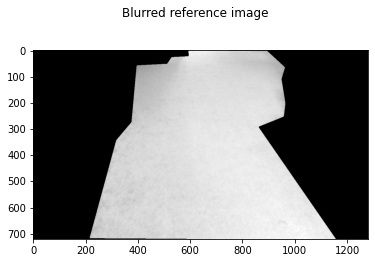

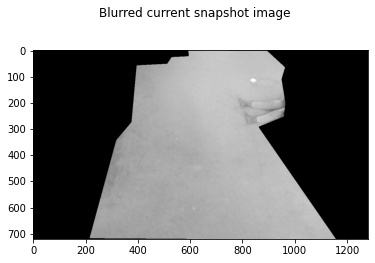

In [19]:
filterSize = 5
ref_median = cv2.medianBlur(gray_ref_image, filterSize)
snap_median = cv2.medianBlur(gray_snap_image, filterSize)
ref_median = ref_median.astype('float32')
snap_median = snap_median.astype('float32')
i.mdisp(ref_median, 'Blurred reference image')
i.mdisp(snap_median, 'Blurred current snapshot image')

### Identify the difference
The important activity of finding the delta happens here. We subtract the pixel values from reference image to find the pixels that changed in the picture.

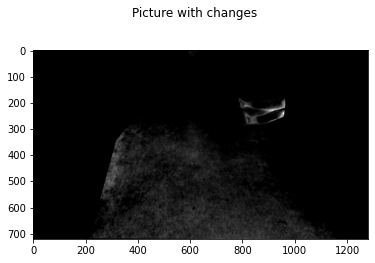

In [20]:
delta_image = np.clip(ref_median - snap_median, 0, 255)
delta_image = delta_image.astype('uint8')
i.mdisp(delta_image, 'Picture with changes')

### Convert greyscale to binary
We need to apply a threshold to the image to force the pixel to be either 0 or 255. We can do this with a threshold. Changing the threshold controls which pixels will be highlighted as change and which will be not

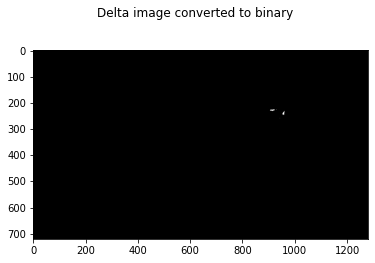

In [21]:
threshValue = 60
_, binaryImage = cv2.threshold(delta_image, threshValue, 255, cv2.THRESH_BINARY)
i.mdisp(binaryImage, 'Delta image converted to binary')

### Filter out small areas
We have to filter areas that showed up in the image, which are really small. Adjusting the minArea parameter adjusts the size of the object that we can find

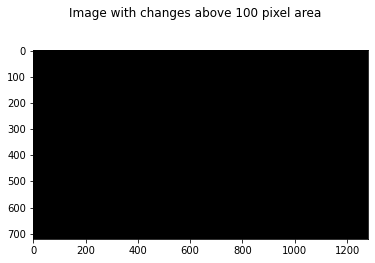

In [11]:
componentsNumber, labeledImage, componentStats, componentCentroids = \
    cv2.connectedComponentsWithStats(binaryImage, connectivity=4)

# Set the minimum pixels for the area filter:
#I set 100 for the remote
minArea = 100

# Get the indices/labels of the remaining components based on the area stat
# (skip the background component at index 0)
remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= minArea]

#print(remainingComponentLabels)
#print(labeledImage)

# Filter the labeled pixels based on the remaining labels,
# assign pixel intensity to 255 (uint8) for the remaining pixels
filteredImage = np.where(np.isin(labeledImage, remainingComponentLabels) == True, 255, 0).astype('uint8')
i.mdisp(filteredImage, 'Image with changes above 100 pixel area')

### Group blobs
Due to pixel intensity a single object might be shown as multiple objects. We can group objects that appear close by using morphology close in opencv

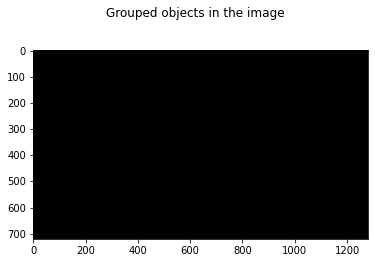

In [40]:
#group nearby polygons into a big polygon
thresh_gray = cv2.morphologyEx(filteredImage, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (51,51)));
i.mdisp(thresh_gray, 'Grouped objects in the image')

### Get all the objects from the image
We have to get all the objects from the snapshot image as well as objects that appeared previously. We need the objects we saw earlier to flag them. If an object appears only once, we don't need to flag them. Otherwise, app would start flagging people moving around in the frame

In [43]:
# Find the big contours/blobs on the filtered image:
existing_objects = f.get_existing_objects(data_filename)
_,contours, hierarchy = cv2.findContours(thresh_gray, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
all_objects, matched_objects = o.get_matched_objects(contours, hierarchy, existing_objects)

#store the objects found
f.write_existing_objects(data_filename, all_objects)
print('all_objects', all_objects)
print('matched_objects', matched_objects)


all_objects [(761, 151, 24, 62), (621, 144, 35, 51)]
matched_objects [(761, 151, 24, 62), (621, 144, 35, 51)]


### Get individual objects list and final image
We need a list of image of objects found and a final image that contains all the rectangles that we need to display in the tv

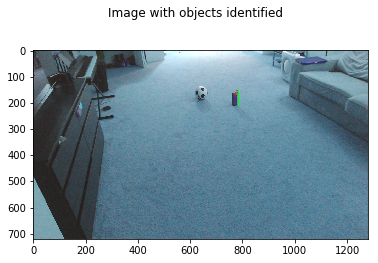

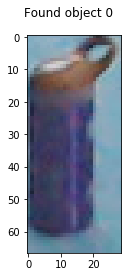

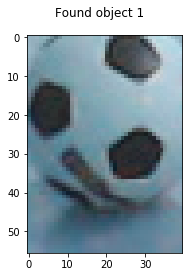

[None, None]

In [44]:
cropped_images, final_image = o.identify_objects(snapshot_image.copy(), matched_objects)
i.mdisp(final_image, 'Image with objects identified')
[i.mdisp(x,'Found object '+str(idx)) for idx,x in enumerate(cropped_images)]

### Display on tv
If we find any object that has been in the same place twice, we can display it on tv. enable_warning and disable_warning are mqtt messages to my nodered server to log.

In [52]:
if len(matched_objects) > 0:
    cv2.imwrite(detected_filename, final_image)
    f.stored_cropped_images(objects_found_dir, cropped_images)
    r.launch_app(roku_ip)    
    m.enable_warning()
    p.stream_picture(plex, plex_client_name, plex_library_name)
else:
    m.disable_warning()

writing to /home/pi/litter_storage/objects_found/2021-01-03_20-06-38_0.jpg
writing to /home/pi/litter_storage/objects_found/2021-01-03_20-06-38_1.jpg
data published 



### Reference
- [how-can-i-get-a-list-of-objects-that-appeared-newly-in-an-image-with-opencv](https://stackoverflow.com/questions/65507967/how-can-i-get-a-list-of-objects-that-appeared-newly-in-an-image-with-opencv/65515341?noredirect=1#comment115830581_65515341)